# CartPole Experiment

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import gymnasium as gym
from IPython import display
plt.rcParams['figure.dpi'] = 150

In [2]:
# What do I want to do here?

# Cartpole is an environment provided by OpenAI gym.
# This is one of the basic RL envs - has been described as the "Hello World" of RL 
# The state is defined by the observation - this has cart position, cart velocity, pole angle, and pole
# angular velocity in that order (numbers output from env.reset())
# env.step(action = 0 or 1) gives us observation, reward, done, info, in that order
# reward = +1 for every additional step, including termination step
# More info can be found here: https://www.gymlibrary.dev/environments/classic_control/cart_pole/

# I want use a DQN algorithm to train an agent to complete this environment successfully
# I plan on experimenting with different:
# a) neural net architectures
# b) learning rates 
# c) explore / exploit values

In [347]:
class DQNAgent():
    """
    RL agent that utilizes a DQN algorithm to solve the Cartpole environment.
    """
    
    def __init__(self, gamma=0.95, epsilon=0.9, epsilon_decay=0.99, epsilon_min=0.01, tau=0.99):
        """
        Initialize agent.
        
        Arguments:
            gamma (float): Future reward discounting factor
            epsilon (float): Starting value representing percentage of the time that the agent chooses a random action. E.g 0.75 = 75%
            epsilon_decay (float): Epsilon is multiplied by this factor after each training step.
            epsilon_min (float): Minimum value for epsilon.
            tau (float): Rate at which the target-q network is updated.
            
        Returns:
            None
        """
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.tau = tau
        self.q_function = self.make_q_function()
        self.q_function.compile(loss='mse', optimizer='adam')
        self.target_q = self.make_q_function()
        self.target_q.compile(loss='mse', optimizer='adam')
        self.target_q.set_weights(self.q_function.weights)
        self.max_memory = 5000
    
    
    def find_action(self, state):
        """
        Taking an action according to current policy of the agent. 
        
        Arguments:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
        
        Returns:
            action (int): 0 or 1, corresponding to whether to push the cart left or right.
        """
        
        # If random float is less than epsilon, we choose the action randomly
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, 2)
            
        # Otherwise, choose the action that is the agent's current best guess for max future reward
        else:
            # Find action with best q-value
            # Find q-value estimates for each action using q-function
            q_vals = self.q_function.predict(state[np.newaxis, :], verbose=False)
            # Find best value by taking index of the largest argument
            action = np.argmax(q_vals)
    
        return action
    
    
    def take_step(self, env):
        """
        Take a step in the Cartpole environment with the agent.
        
        Arguments:
            env: Cartpole environment object
        
        Returns:
            state (ndarray): cart position, cart velocity, pole angle, and pole angular velocity
            reward (int): +1 if the episode has not yet terminated, 0 otherwise
            done (bool): Whether or not episode has terminated
            action (int): 1 or 0, corresponding to whether the cart was pushed left or right
            info (dict): Empty dictionary
        """
        
        action = self.find_action(self.state)
        state, reward, done, info = env.step(action)[:4]
        self.state = state
        return state, reward, action, done
    
    
    def make_q_function(self):
        """
        Create a q-function to estimate future reward values for a given state-action pair.
        
        Arguments:
            None
        
        Returns:
            model: Untrained Keras sequential model. 
        """
        
        model = Sequential(
            [
                Dense(128, activation='relu', input_shape=(4,)),
                Dense(128, activation='relu'),
                Dense(100, activation='relu'),
                Dense(64, activation='relu'),
                Dense(2, activation='linear')
            ]
        )
        
        return model
        
    
    def train(self):
        """
        Use memory of experience to train agent using gradient descent.
        
        Arguments:
            None
            
        Returns:
            None
        """
            
        # Define target q = reward + gamma * target q of next state
#         future_reward = self.target_q.predict(self.memory[:, -4:], verbose='False')
#         done_array = np.concatenate((self.memory[:, 6].reshape(self.memory.shape[0], 1), self.memory[:, 6].reshape(self.memory.shape[0], 1)), axis=1)
#         future_reward = np.where(done_array, 0, future_reward)
        
#         future_reward = np.max(self.target_q.predict(self.memory[:, -4:], verbose='False'), axis=1)
#         future_reward = np.where(self.memory[:, 6], 0, future_reward)
        
        future_reward = np.max(self.q_function.predict(self.memory[:, -4:], verbose='False'), axis=1)
        future_reward = np.where(self.memory[:, 6], 0, future_reward)
        
#         reward_array = np.concatenate((self.memory[:, 4].reshape(self.memory.shape[0], 1), self.memory[:, 4].reshape(self.memory.shape[0], 1)), axis=1)
        target_vals = self.memory[:, 4] + self.gamma * future_reward                                            
        
        # Train q-function with mse against target-q
        self.q_function.fit(self.memory[:, :4], target_vals, shuffle=True, batch_size=32, verbose=False)
        
        # Update target-q to be tau * target q weights + (1 - tau) * q weights
#         new_weights = [self.tau * i + (1 - self.tau) * j for i, j in zip(self.target_q.weights, self.q_function.weights)]
#         self.target_q.set_weights(new_weights) 
        
        # Update epsilon
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon, self.epsilon_min)
        
        
    def go(self, env, num_rounds=100, train_freq=5):
        """
        Run the agent till termination num_rounds times.
        
        Arguments:
            env: Cartpole environment object
            num_rounds (int): Number of times we want the agent to run until termination.
            train_freq (int): Train the agent after every train_freq rounds.
            
        Returns:
            None
        """
        
        self.memory = np.zeros((1, 11))
        length_lst = []
        
        # Each round is a complete runthrough of the environment until termination
        for i in tqdm(range(num_rounds)):
            
            # Tracking whether or not current iteration has terminated
            complete = False
            
            # Resetting to initial state
            self.state = env.reset()[0]
            
            # Variable to keep data from this round
            data_track = np.zeros((1, 11))
            
            # Variable to keep track of number of steps taken in each round
            length = 0
            
            while not complete:
                
                state, reward, action, done = self.take_step(env)
                
                # Add data to current iteration memory
                if data_track.any():
                    curr_data = np.append(state, (reward, action, done, 0, 0, 0, 0)).reshape((1, 11))
                    data_track = np.concatenate((data_track, curr_data), axis=0)
                else: 
                    data_track = np.append(state, (reward, action, done, 0, 0, 0, 0))
                    data_track = data_track.reshape((1, 11))
                
                # Add training
                if length % train_freq == 0:
                    self.train()
                
                if done:
                    complete = True
                    
                length += 1
            
            data_track[:, -4:] = np.roll(data_track[:, :4], -1, axis=0)
            
            if self.memory.any():
                self.memory = np.concatenate((self.memory, data_track))
            else:
                self.memory = data_track
                
            if len(self.memory) > self.max_memory:
                idx = np.random.randint(0, self.max_memory + 1, size=self.max_memory) 
                self.memory = self.memory[idx, :]
            
            length_lst.append(length)
                               
        return length_lst


In [348]:
agent = DQNAgent()

In [349]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [350]:
lengths = agent.go(env, num_rounds=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.61it/s]


Text(0, 0.5, 'Episode length')

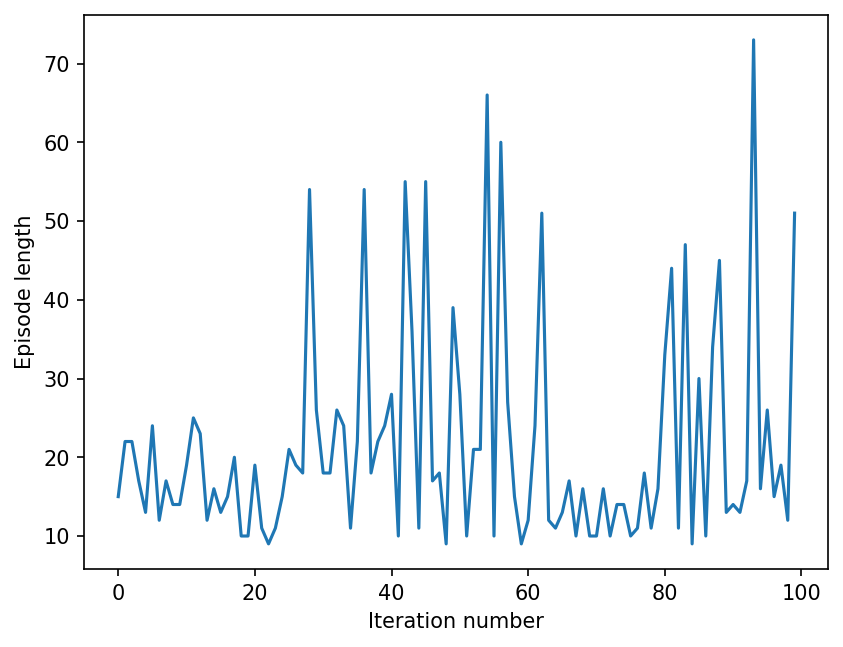

In [351]:
iters = np.arange(100)
plt.plot(iters, lengths)
plt.xlabel("Iteration number")
plt.ylabel("Episode length")

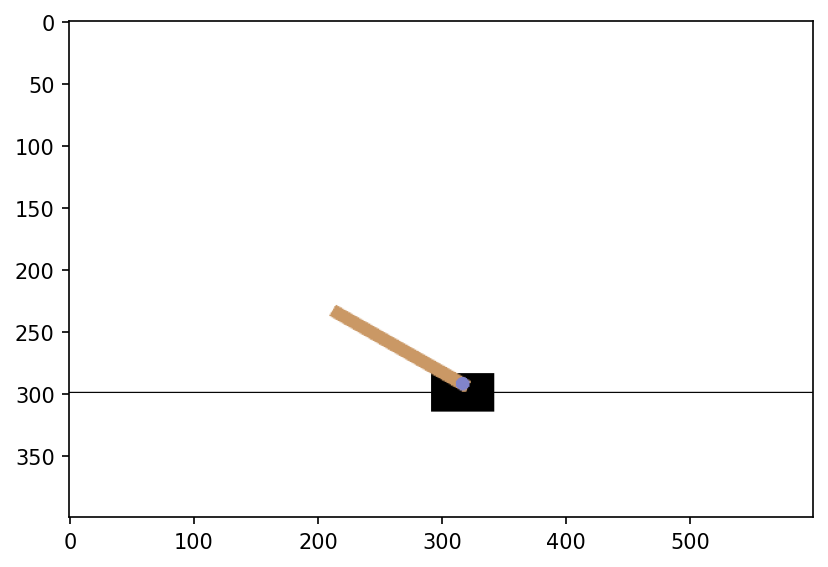

In [231]:
for i in range(25):
   plt.imshow(env.render())
   display.display(plt.gcf())    
   display.clear_output(wait=True)
   env.step(env.action_space.sample()) # take a random action

env.close()